In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import json
import os
from scipy.optimize import minimize_scalar
from scipy import stats
import pandas as pd

In [8]:
dir_list = [el for el in os.listdir() if el.startswith("run_ger")]
dir_list.sort(key=lambda x: os.path.getmtime(x))
run = dir_list[-1]
print(dir_list)
print("plotting run : {}".format(run))

['run_ger_2023-02-11_13-27-38', 'run_ger_2023-02-11_13-30-33', 'run_ger_2023-02-11_13-33-56', 'run_ger_2023-02-11_13-35-35', 'run_ger_2023-02-11_13-37-44', 'run_ger_2023-02-11_13-39-22']
plotting run : run_ger_2023-02-11_13-39-22


In [9]:
#gamma, log likelihood
df_list = []
run_high = None
lik_high = 0.0
for run in dir_list:
    arr = np.load(run + "/posterior_first.npz")
    data = np.load(run + "/data_info.npz")
    lik = stats.norm.logpdf(np.log(data["sir_data"][:, 0]),
                            loc=arr["means"][::25, 0],
                            scale=np.sqrt(arr["covs"][::25, 0, 0])).sum()
    if lik > lik_high : 
        run_high = run
        lik_high = lik
    df_list.append((data["gamma"], lik))
df = pd.DataFrame(df_list, columns=["Gamma", "LogLik"])
df.sort_values(by="LogLik", ascending=False)

,Gamma,LogLik
5,0.0,4601.175989
4,0.01,4461.494448
3,0.03,4363.240450
2,0.04,4358.280435
1,0.05,4338.479281
0,0.06,4328.491131


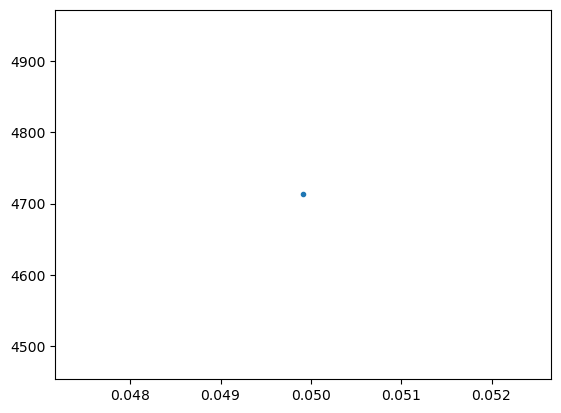

In [148]:
plt.plot(df["Gamma"], df["LogLik"], '.')

In [149]:
run_high = dir_list[-1]
arr_test = np.load(run_high + "/posterior_first.npz")
data_test = np.load(run_high + "/data_info.npz")

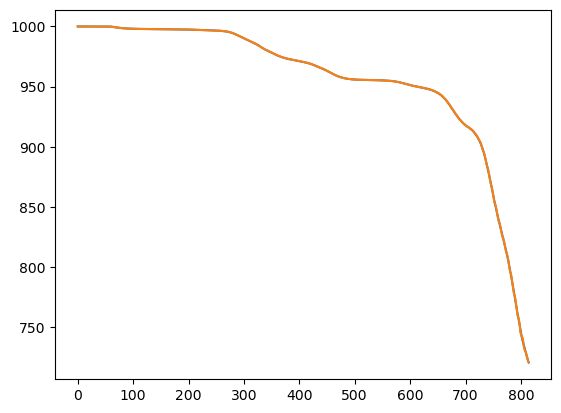

In [150]:
#plot best gamma's cumulative cases
plt.plot(np.exp(arr_test["means"][::25, 0]))
plt.plot(data_test["sir_data"][:,0])

In [151]:
logS = arr_test["means"][:, 0]
S = np.exp(logS)
logSp = arr_test["means"][:, 1]
Sp = S * logSp

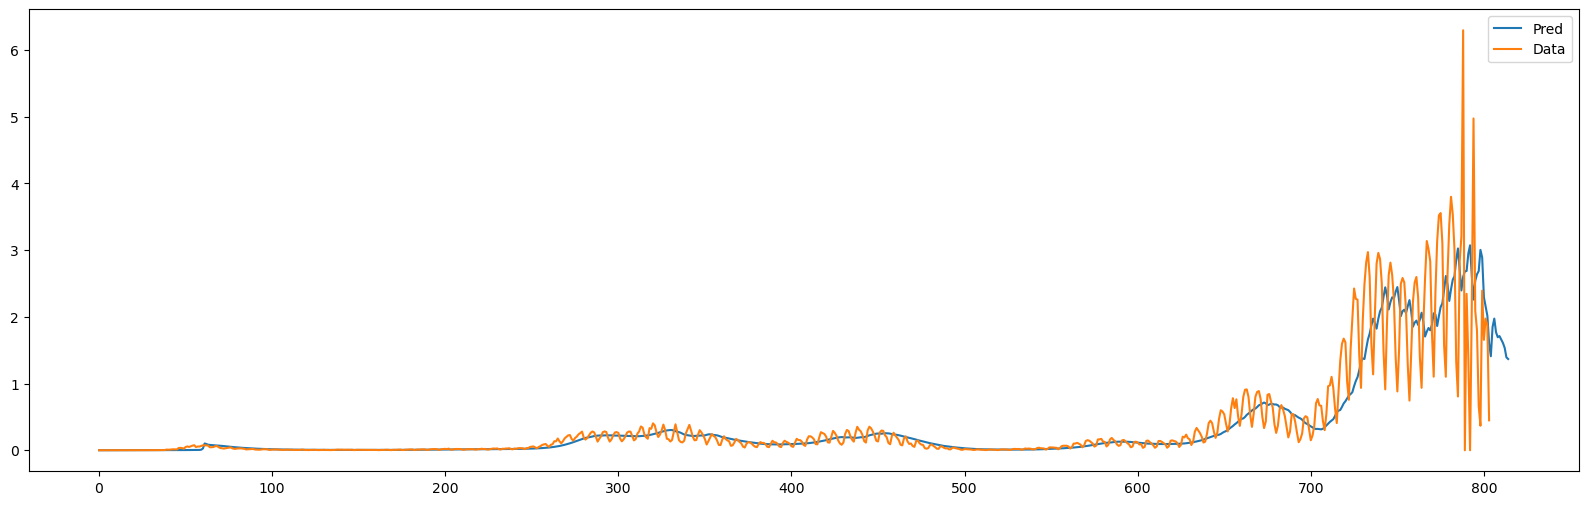

In [152]:
plt.figure(figsize=(20,6))
plt.plot(-Sp[10::25], label="Pred")
plt.plot(-np.diff(data_test["sir_data"][10:, 0]), label="Data")
plt.legend()

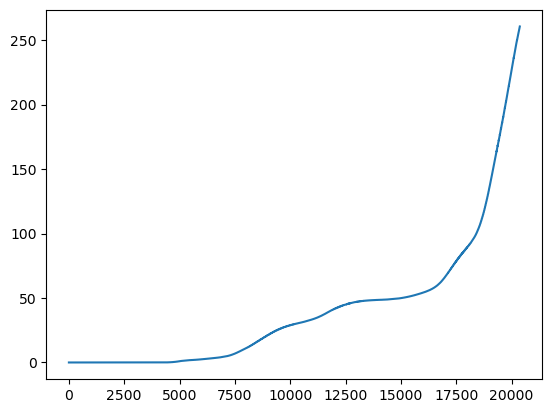

In [137]:
logR = arr["means"][:, 6]
R = np.exp(logR)
logRp = arr["means"][:, 7]
Rp = R * logRp
plt.plot(R)

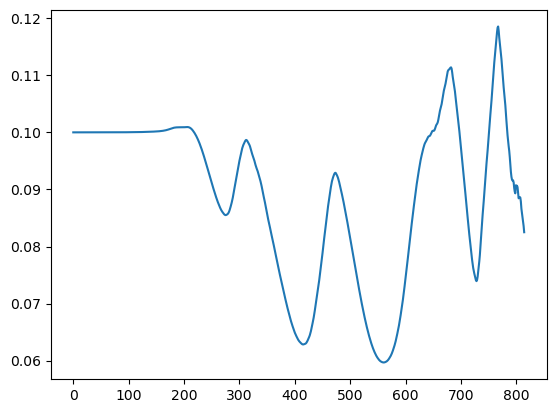

In [138]:
def beta_link_fn(x, info, data, y_offset=0.0):
    slope = info["sigmoid_slope"]
    x_offset = -scipy.special.logit(data["beta_prior_mean"])
    return scipy.special.expit(slope * (x - x_offset)) + y_offset

with open(run_high + "/info.json") as f:
    info = json.load(f)
    
plt.plot(beta_link_fn(arr["means"][:,-2][::1+int(1/info["filter_step_size"])], info, data))